In [7]:
import torch
import torch.nn as nn
import os
from tqdm.notebook import tqdm

from ode_nn import AutoODE_COVID, weight_fun
from ode_nn import Dataset, train_epoch, eval_epoch, get_lr
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt
import random
import warnings
from ode_nn import Dataset_graph, train_epoch_graph, eval_epoch_graph, get_lr
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

## Data Preprocessing

In [3]:
# Read and Preprocess the csv files from John Hopkins Dataset
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports_us
direc = "../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/" # Directory that contains daily report csv files.

dates = [c for c in os.listdir(direc) if c.endswith('.csv')]
list_csv = sorted(dates, key=lambda s: (s[6:], s[:6]))  # mm-dd-yyyy.csv to yyyy.csv, mm-dd-
# XXX *not* their original code, which had Jan 2021 before May 2020 :(

us = []
for file in list_csv:
    sample = (
        pd.read_csv(os.path.join(direc, file))
          .set_index("Province_State")[["Confirmed", "Recovered", "Deaths"]]
          .sort_values(by = "Confirmed", ascending = False)
          # XXX  Is this really how we want it sorted? What order is the adjacency matrix below in?
    )
    us.append(sample.drop(['Diamond Princess', 'Grand Princess']))
us = pd.concat(us, axis=1, join='inner')
us_data = us.values.reshape(56,-1,3)
us_data[us_data!=us_data] = 0
# XXX   Do we really want this to be 0? Lots of states (CA, FL, IL, ...) never use it

#####################################################################################
# Normalize by total population of each state
population = pd.read_csv("ode_nn/population_states.csv", index_col=0)
scaler = population.loc[us.index].values.reshape(56, 1, 1)*1e6
us_data = us_data/scaler
us_data = torch.from_numpy(us_data).float().to(device)

# Mobility Data: beta = 1 - stay_at_home_percentages
beta = torch.load("ode_nn/mobility/us_beta.pt").float()

# U.S states 1-0 Adjacency Matrix
graph = torch.load("ode_nn/mobility/us_graph.pt").float()

In [19]:
us.head()

,Confirmed,Recovered,Deaths,Confirmed,Recovered,Deaths,Confirmed,Recovered,Deaths,Confirmed,...,Deaths,Confirmed,Recovered,Deaths,Confirmed,Recovered,Deaths,Confirmed,Recovered,Deaths
Province_State,,,,,,,,,,,,,,,,,,,,,
California,2365024,NaN,26363,2415246,NaN,26551,2452262,NaN,26638,2490518,...,24546,2258759,NaN,24988,2291414,NaN,25417,2325599,NaN,25986
Texas,1782956,1435164.0,28359,1801181,1443061.0,28442,1816886,1451846.0,28496,1831146,...,27205,1732971,1387358.0,27436,1754975,1402336.0,27741,1772784,1423001.0,28066
Florida,1323315,NaN,21673,1354833,NaN,21890,1365436,NaN,21987,1376692,...,21308,1292252,NaN,21409,1306123,NaN,21546,1323315,NaN,21673
New York,995816,102968.0,38155,1011665,103828.0,38273,1023897,104402.0,38415,1035139,...,37548,950473,100442.0,37687,963390,101295.0,37840,978783,102129.0,37983
Illinois,963389,NaN,17978,975352,NaN,18217,979821,NaN,18322,984880,...,17470,948006,NaN,17596,955380,NaN,17811,963389,NaN,17978


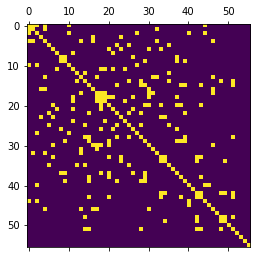

In [5]:
plt.matshow(graph.numpy())

## Train AutoODE-COVID

In [8]:
##################################################################
test_idx = 131

# Learning Rate
lr = 0.01

# number of historic data points for fitting
input_steps = 10 

# forecasting horizon
output_steps = 7

# number of epochs for training
num_epochs = 20000

# select data for training
data = us_data[:, test_idx-input_steps:test_idx+7]
y_exact = data[:,:input_steps]

##################################################################

# XXX   Are they using I, R, D correctly??? It seems like maybe no...(daily diffs versus totals, etc)


model = AutoODE_COVID(initial_I = data[:,0,0], initial_R = data[:,0,1], initial_D = data[:,0,2],
                      num_regions = 56, solver = "RK4", n_breaks = 1, graph = graph).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1000, gamma=0.9)
loss_fun = torch.nn.MSELoss()
min_loss = 1

##################################################################

for e in tqdm(range(num_epochs)):
    scheduler.step()
    y_approx = model(input_steps)
    loss = loss_fun(y_approx[:,:,-3:], y_exact[:,:input_steps,-3:])
    
######## Weighted Loss ########
#     loss_weight = weight_fun(input_steps, function = "sqrt", feat_weight = True)
#     loss = torch.mean(loss_weight*loss_fun(y_approx[:,:,-3:], y_exact[:,:input_steps,-3:])) 

######## A few constraints that can potential improve the model ######## 
#     positive_constraint = loss_fun(F.relu(-model.beta), torch.tensor(0.0).float().to(device))
#     diagonal_constraint = loss_fun(torch.diagonal(model.A, 0),torch.tensor(1.0).float().to(device))
#     initial_constraint = loss_fun(model.init_S + model.init_E + model.init_I + model.init_R + model.init_U, torch.tensor(1.0).float().to(device))
#     loss += initial_constraint + positive_constraint + diagonal_constraint 
   
    if loss.item() < min_loss:
        best_model = model
        min_loss = loss.item()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
#     if e%1000 == 0:
#         y_approx2 = model(data.shape[1]).data.numpy()
#         y_exact2 = data.data.numpy()
#         print(list_csv[test_idx][:10])
#         #torch.mean(torch.abs(y_approx - y_exact)[:,-7:]).data, torch.mean(torch.abs(y_approx - y_exact)[:,30:]).data
#         for i in range(3):
#             print(np.mean(np.abs(y_approx2*scaler - y_exact2*scaler)[:,-7:, i]))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [10]:
name = "autoode-covid"
y_approx = best_model(data.shape[1]).cpu().data.numpy()
y_exact = data.cpu().data.numpy()
print(list_csv[test_idx][:10])
#torch.mean(torch.abs(y_approx - y_exact)[:,-7:]).data, torch.mean(torch.abs(y_approx - y_exact)[:,30:]).data
for i in range(3):
    print(np.mean(np.abs(y_approx*scaler - y_exact*scaler)[:,-7:, i]))
    
torch.save({"model": best_model,
            "preds": y_approx*scaler,
            "trues": y_exact*scaler},
            ".pt")

05-18-2020
326.36781868259953
901.7405160169485
169.3536832595483


In [14]:
us_data.shape

torch.Size([56, 359, 3])

In [13]:
y_approx.shape

(56, 17, 3)